## 모듈 불러오기

In [1]:
! nvidia-smi

Wed Aug  4 06:38:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    45W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install konlpy

In [4]:
!cp '/content/drive/MyDrive/Github/Ryles_Practice/NLP/DL/preprocess.py' .

In [5]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

## 그래프 만들 때 쓸 함수 생성

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'vla_' + string])
    plt.show()

## 경로 지정

In [7]:
PATH = '/content/drive/MyDrive/Github/Ryles_Practice/'
DATA_IN_PATH = PATH+'DATA/data_in/'
DATA_OUT_PATH = PATH+'DATA/data_out/'
TRAIN_INPUTS = 'train_inputs.npy' # numpy 확장자 npy (구조 유지하는 binary 포맷)
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_tragets.npy'
DATA_CONFIG = 'data_configs.json'

## SEED 지정

In [8]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

## 파일들 불러오기 

In [9]:
import json

In [10]:
index_inputs = np.load(open(DATA_IN_PATH+TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH+TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(DATA_IN_PATH+TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH+DATA_CONFIG, 'r'))

## 모델 기본 파라미터 설정 및 필요 데이터 가져오기

In [11]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25
EPOCHS = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']
sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size']

## 인코더 만들기

In [12]:
class Encoder(tf.keras.layers.Layer): # layer 상속받아서 layer의 역할을 한다.
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size): 
        super(Encoder, self).__init__() # 상속 받았으니 부모 객체 불러와야 함.
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences = True, return_state = True, recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initial_hidden_state(self, input):
        return tf.zeros((tf.shape(input)[0], self.enc_units))

## Attention

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # value의 shape가 (batch_size, maxlen, hidden_size)니까 query에도 차원을 추가해 주는 것. 안 해주면 (batch_size, hidden_size)
        # tf.expand_dims(인풋, axis=) 0이면 0번째 인덱스에 차원 추가, 1이면 두번째 인덱스에 차원 추가(열), -1하면 마지막에 차원 추가 
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

## 디코더 만들기

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
        
        # vocab_size 유닛을 통과하여 확률값 뽑을 수 있도록 fully_connection
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        
        # attention
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x)
        # output의 형태를 2차원으로 만드는데, 마지막(2)번째를 남기고 나머지는 알아서 결정하라! (가운데가 1이니까 앞에를 자동 선택하겠지)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights        

In [15]:
optimizer = tf.keras.optimizers.Adam()

# from_logit은 내부에서 softmax 할지 말지 결정, true로 두면 softmax 안하고 그냥 logit 가져옴
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [16]:
def loss(real, pred):
    # tf.math.equal(real, 0): real 데이터가 0과 같은지 확인 (bool 형태의 tensor), 즉 패딩인지 확인하는 것
    # tf.math.logical_not은 true를 false로 바꿔주는 것 (즉 패딩인 것을 false로 바꿔주기 위해 사용)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_fn(real, pred)
    
    # mask와 loss_의 타입을 같게 만들어 줌
    
    # tf.cast?
    # 텐서를 새로운 형태로 캐스팅하는데 사용한다.
    # 부동소수점형에서 정수형으로 바꾼 경우 소수점 버린을 한다.
    # Boolean형태인 경우 True이면 1, False이면 0을 출력한다.
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # loss에 개별적으로 mask를 곱해주어 패딩되어 있는 부분의 loss는 계산되지 않게 하는 것
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)
    
    return tf.reduce_mean(acc)

In [17]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_id = EOS_INDEX):
        super(Seq2Seq, self).__init__()
        self.end_token_id = end_token_id
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)
        
    def call(self, x):
        input, target = x
        
        enc_hidden = self.encoder.initial_hidden_state(input)
        enc_output, enc_hidden = self.encoder(input, enc_hidden)
        
        dec_hidden = enc_hidden
        
        predict_tokens = []
        
        for t in range(target.shape[1]):
            # teacher forcing: 원래는 pred가 다음으로 cell로 들어가지만, 학습이 잘 안 되기 때문에 target을 바로 dec의 인풋으로 넣어주는 것
            dec_input = tf.dtypes.cast(tf.expand_dims(target[:, t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
            
        return tf.stack(predict_tokens, axis=1)

    def inference(self, x):
        input = x

        enc_hidden = self.encoder.initial_hidden_state(input)
        enc_output, enc_hidden = self.encoder(input, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([word2idx[sos_idx]], 1)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])

            if predict_token == self.end_token_id:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy()

In [18]:
model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE)
model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy])

### 시간이 굉장히 오래걸리니 google colab GPU 사용할 것 (CPU:에폭당 11분)

In [19]:
PATH = DATA_OUT_PATH + MODEL_NAME

## 디렉토리 없으면 만들기
if not (os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))

## 얼리스탑 및 모델 저장 위치 지정
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + "/weights.h5"
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, save_weights_only=True)

## min_delta는 최소 차이가 0.0001은 나야한다는 것
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
444/444 [==============================] - 116s 178ms/step - loss: 1.4852 - accuracy: 0.7917 - val_loss: 1.5689 - val_accuracy: 0.7953

Epoch 00001: val_accuracy improved from -inf to 0.79533, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/data_out/seq2seq_kor/weights.h5
Epoch 2/30
444/444 [==============================] - 72s 162ms/step - loss: 1.1703 - accuracy: 0.8016 - val_loss: 1.4968 - val_accuracy: 0.8066

Epoch 00002: val_accuracy improved from 0.79533 to 0.80656, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/data_out/seq2seq_kor/weights.h5
Epoch 3/30
444/444 [==============================] - 72s 163ms/step - loss: 0.9958 - accuracy: 0.8114 - val_loss: 1.5118 - val_accuracy: 0.8151

Epoch 00003: val_accuracy improved from 0.80656 to 0.81506, saving model to /content/drive/MyDrive/Github/Ryles_Practice/DATA/data_out/seq2seq_kor/weights.h5
Epoch 4/30
444/444 [==============================] - 71s 161ms/step - loss: 0.8383 - accu

In [20]:
model.load_weights(os.path.join(PATH+'/weights.h5'))

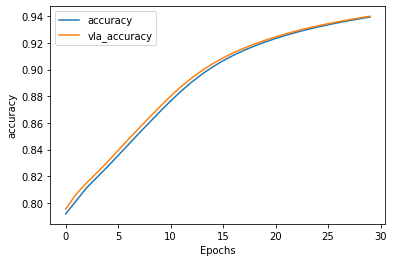

In [21]:
plot_graphs(history, 'accuracy')

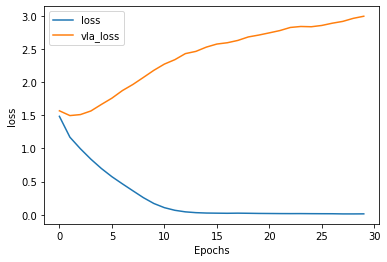

In [22]:
plot_graphs(history, 'loss')

In [31]:
query = "남자친구 승진 선물로 뭐가 좋을까?"

test_index_inputs, _ = enc_processing([query], word2idx)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(" ".join([idx2word[str(t)] for  t in predict_tokens]))

[ 1599   275 11789  3500   594  4541  9502]
평소 에 필요했던 게 좋을 것 같아요
